# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [46]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [48]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [49]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [50]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [51]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7f864f2622c0>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f864c95b130>])

### Embedding 모델 선택

In [52]:
from langchain.embeddings import BedrockEmbeddings

In [53]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [54]:
import boto3
from utils.ssm import parameter_store

In [55]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [56]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [57]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [58]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: kb_complex_pdf


### OpenSearch Client 생성

In [59]:
from utils.opensearch import opensearch_utils

In [60]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [61]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [62]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=False, # enable reranker with reranker model
    #reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document = False, # enable parent document
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=True,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=False,
)

### QA chain 정의

In [63]:
system_prompt = prompt_repo.get_system_prompt()

In [64]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=True
)

당분기(2023년 3월 31일) 삼성생명보험의 자산총계는 2조 6,556억원입니다.
-----------------------------------------------
1. Category: Table, Chunk: 194 Characters
-----------------------------------------------
이 표는 보험회사의 2023년 3월 31일 당분기와 2022년 3월 31일 전년동기의 재무상태표를 보여줍니다. 주요 자산항목으로는 현금및예치금, 유가증권, 대출채권 등이 있고,
부채항목으로는 책임준비금, 계약자지분조정, 기타부채 등이 있습니다. 당분기 자산총계는 2조 6,556억원, 부채총계는 2조 3,191억원, 자본총계는 3,365억원입니다.
metadata:
 {'source': './data/complex_pdf/l-test.pdf', 'detection_class_prob': 0.915132999420166,
'coordinates': {'points': [[200.8492889404297, 374.9202575683594], [200.8492889404297,
1957.1298828125], [1554.8375244140625, 1957.1298828125], [1554.8375244140625, 374.9202575683594]],
'system': 'PixelSpace', 'layout_width': 1654, 'layout_height': 2339}, 'last_modified':
'2024-03-25T04:44:29', 'text_as_html': '<table><thead><th rowspan="2"></th><th colspan="2">당 분 기
(2023.3.31)</th><th colspan="2">전 년 동? (2022.3.31)</th></thead><thead><th></th><th>금액</th><th>구성비</t
h><th></th><th>구성비</th></thead><tr><td></td><td>24,

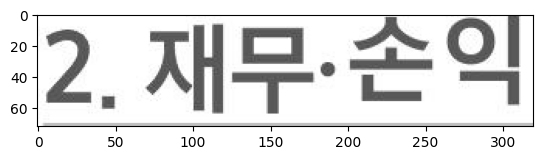

주어진 이미지는 한글 텍스트로 "2. 재무·손익"이라고 적혀있습니다. 이는 아마도 문서나 보고서의 제목 또는 목차 중 하나일 것으로 보입니다. 검정색 글씨체로 단순하게 표기되어
있습니다.
metadata:
 {'img_path': './fig/figure-1-1.jpg', 'category': 'Image', 'image_base64': '', 'id':
'a130f6fe-4ed2-4d17-9d7d-3036edfce088', 'origin_image': ''}

-----------------------------------------------
4. Category: CompositeElement, Chunk: 39 Characters
-----------------------------------------------
2. 재무∙손익 2-2. 요약 재무상태표(총괄) (단위 : 억원, %)
metadata:
 {'source': './data/complex_pdf/l-test.pdf', 'filetype': 'application/pdf', 'languages': ['kor',
'eng'], 'last_modified': '2024-03-25T04:44:29', 'page_number': 1, 'file_directory':
'./data/complex_pdf', 'filename': 'l-test.pdf', 'category': 'CompositeElement', 'id':
'3c6ef592-72ac-4bcb-bd24-1d764efe946b'}

-----------------------------------------------
5. Category: Image, Chunk: 124 Characters
-----------------------------------------------


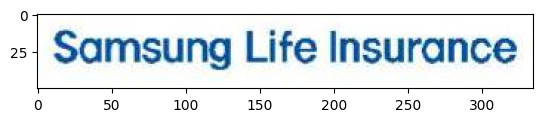

이미지는 삼성생명보험의 로고를 보여주고 있습니다. 푸른색과 하늘색 계열의 색상이 사용되었으며, 'Samsung Life Insurance'라는 영문 문구가 상단에 있습니다. 로고
디자인은 심플하고 모던한 스타일로 보입니다.
metadata:
 {'img_path': './fig/figure-1-2.jpg', 'category': 'Image', 'image_base64': '', 'id':
'1a015760-4655-4190-a6a1-378a9c686dbc', 'origin_image': ''}


In [70]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

#query = "수익률 그래프 설명해줘"
#query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "전년 동기 현금 예치금 구성비 알려줘"
query = "자산총계 금액 알려줘"

#query = "대출채권의 전년동기에 해당하는 구성비는 얼마입니까?"
#query = "당기손익-공정가치측정유가증권 전년동기의 구성비는?"
response, contexts = qa.invoke(
    query = query,
    verbose=False
)

show_context_used(contexts)

### Parameter updates

In [66]:
opensearch_hybrid_retriever.update_search_params(
    k=8,
    minimum_should_match=0,
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=False
)

In [67]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

query = "기준 자산가치가 100% 일 때 수익률은?"
query = "수익률 그래프 설명해줘"


In [ ]:
response, contexts = qa.invoke(
    query = query,
    verbose=True
)

In [22]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)

##################################
query:  수익률 그래프 설명해줘
##################################


### Answer ###


NameError: name 'response' is not defined